## Linear Regression

In this project, I focus on applying **Linear Regression** to predict rental prices for residential properties in Kuala Lumpur and Selangor, Malaysia.

The dataset was sourced from [Kaggle](https://www.kaggle.com/datasets/ariewijaya/rent-pricing-kuala-lumpur-malaysi?resource=download), containing around 19000 rental listings scraped from mudah.my, one of Malaysia’s major property platforms

## Dataset Summary
The dataset includes 13 features and 1 target variable:

**Target**: `monthly_rent` – monthly rental price in Malaysian Ringgit (RM)


**Key Features:**

`ads_id:` the listing ids (unique)

`prop_name`: name of the building/ property

`completion_year`: completion/ established year of the property

`location`: property location in Kuala Lumpur region

`property_type`:property type such as apartment, condominium, flat, duplex, studio, etc

`rooms:` number of rooms in the unit

`parking`: number of parking space for the unit

`bathroom`: number of bathrooms in the unit

`size`: total area of the unit in square feet

`furnished`: furnishing status of the unit (fully, partial, non-furnished)

`facilities:` main facilities available

`additional_facilities:` additional facilities (proximity to attraction area, mall, school, shopping, railways, etc)


##Methodology: Linear Regression


To build the linear regression model, I followed these steps:


**Preprocessing:**

Removed irrelevant columns (ads_id, prop_name, etc.)

Dropped missing values in critical features

Converted categorical variables (location, property_type, furnished) into dummy variables for regression

Train-Test Split:

Randomly split the dataset into training (80%) and test (20%) sets



**Model Training:**

Used the LinearRegression() model from scikit-learn to fit the training data

Measured training time to assess computational efficiency



**Evaluation:**

Predicted rent prices using the training set

Evaluated model performance using R² Score, Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE)



**Visualization:**

Created a scatter plot of actual vs predicted rent values on the training set

Added a reference line for perfect prediction (y = x)



In [230]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import time
import warnings
warnings.filterwarnings("ignore")


In [231]:
from google.colab import files
uploaded = files.upload()

Saving mudah-apartment-kl-selangor.csv to mudah-apartment-kl-selangor (5).csv


In [232]:
# Load raw dataset
df = pd.read_csv("mudah-apartment-kl-selangor.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19991 entries, 0 to 19990
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ads_id                 19991 non-null  int64  
 1   prop_name              19043 non-null  object 
 2   completion_year        10806 non-null  float64
 3   monthly_rent           19989 non-null  object 
 4   location               19991 non-null  object 
 5   property_type          19991 non-null  object 
 6   rooms                  19985 non-null  object 
 7   parking                14289 non-null  float64
 8   bathroom               19985 non-null  float64
 9   size                   19991 non-null  object 
 10  furnished              19986 non-null  object 
 11  facilities             17782 non-null  object 
 12  additional_facilities  14043 non-null  object 
 13  region                 19991 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 2.1+

In [233]:
df.head()

,ads_id,prop_name,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,facilities,additional_facilities,region
0,100323185,The Hipster @ Taman Desa,2022.0,RM 4 200 per month,Kuala Lumpur - Taman Desa,Condominium,5,2.0,6.0,1842 sq.ft.,Fully Furnished,"Minimart, Gymnasium, Security, Playground, Swi...","Air-Cond, Cooking Allowed, Washing Machine",Kuala Lumpur
1,100203973,Segar Courts,NaN,RM 2 300 per month,Kuala Lumpur - Cheras,Condominium,3,1.0,2.0,1170 sq.ft.,Partially Furnished,"Playground, Parking, Barbeque area, Security, ...","Air-Cond, Cooking Allowed, Near KTM/LRT",Kuala Lumpur
2,100323128,Pangsapuri Teratak Muhibbah 2,NaN,RM 1 000 per month,Kuala Lumpur - Taman Desa,Apartment,3,NaN,2.0,650 sq.ft.,Fully Furnished,"Minimart, Jogging Track, Lift, Swimming Pool",NaN,Kuala Lumpur
3,100191767,Sentul Point Suite Apartment,2020.0,RM 1 700 per month,Kuala Lumpur - Sentul,Apartment,2,1.0,2.0,743 sq.ft.,Partially Furnished,"Parking, Playground, Swimming Pool, Squash Cou...","Cooking Allowed, Near KTM/LRT, Washing Machine",Kuala Lumpur
4,97022692,Arte Mont Kiara,NaN,RM 1 299 per month,Kuala Lumpur - Mont Kiara,Service Residence,1,1.0,1.0,494 sq.ft.,Not Furnished,"Parking, Security, Lift, Swimming Pool, Playgr...",Air-Cond,Kuala Lumpur


**It can be observed that the raw dataset is quite messy. Several issues are identified as follows:**

`ads_id `and `prop_name` may be irrelevant or non-informative variables.

`completion_year` and `parking` contain a large number of missing (NA) values.

`monthly_rent` is incorrectly read as a character (string) due to the presence of "RM" and "per month" in the entries.

`location` is a string-type variable and requires further preprocessing.

`property_type` is also a string and needs to be transformed appropriately.

`rooms` and `bathroom`appear to be fine at first glance.

`size` is incorrectly treated as a string due to the inclusion of "sq.ft".

`furnished` is a string-type variable that also needs to be converted.

`facilities` and `additional_facilities` seem unstructured and require additional processing.

`region` is a string-type variable that also requires transformation.

##Data Pre-processing

**Firstly, check and delete the duplicated data from the raw dataset.**

In [234]:
# Removing ‘RM’ from monthly rent and rename the column
df['monthly_rent'] = df['monthly_rent'].str.replace(r'RM|per month|,', '', regex=True)
df['monthly_rent'] = df['monthly_rent'].str.replace(r'\s+', '', regex=True)
df['monthly_rent'] = pd.to_numeric(df['monthly_rent'], errors='coerce')

df.rename(columns={'monthly_rent': 'monthly_rent_rm'}, inplace=True)

**For monthly_rent, remove the RM, per month, transform it as numeric and rename the column as monthly_rent_rm.**

In [235]:
# Dropping ‘sq.ft’ from size
df['size'] = df['size'].str.extract(r'(.*?)(?=\s*sq)', expand=False)
df['size'] = pd.to_numeric(df['size'], errors='coerce')

df.rename(columns={'size': 'size_sqft'}, inplace=True)

**For size, remove the sq.ft, transform it as numeric and and rename the column as size_sqft.**

In [236]:
# This step standardizes the location column by removing any additional neighborhood details after the main region name (e.g., "Kuala Lumpur - Taman Desa" becomes "Kuala Lumpur").
# This helps in consistent grouping and regional analysis

df['location_cleaned'] = df['location'].str.extract(r'^(Kuala Lumpur|Selangor)', expand=False)

df['location_encoded'] = df['location_cleaned'].map({'Kuala Lumpur': 1, 'Selangor': 2})


In [237]:
df.head()

,ads_id,prop_name,completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,facilities,additional_facilities,region,location_cleaned,location_encoded
0,100323185,The Hipster @ Taman Desa,2022.0,4200.0,Kuala Lumpur - Taman Desa,Condominium,5,2.0,6.0,1842,Fully Furnished,"Minimart, Gymnasium, Security, Playground, Swi...","Air-Cond, Cooking Allowed, Washing Machine",Kuala Lumpur,Kuala Lumpur,1
1,100203973,Segar Courts,NaN,2300.0,Kuala Lumpur - Cheras,Condominium,3,1.0,2.0,1170,Partially Furnished,"Playground, Parking, Barbeque area, Security, ...","Air-Cond, Cooking Allowed, Near KTM/LRT",Kuala Lumpur,Kuala Lumpur,1
2,100323128,Pangsapuri Teratak Muhibbah 2,NaN,1000.0,Kuala Lumpur - Taman Desa,Apartment,3,NaN,2.0,650,Fully Furnished,"Minimart, Jogging Track, Lift, Swimming Pool",NaN,Kuala Lumpur,Kuala Lumpur,1
3,100191767,Sentul Point Suite Apartment,2020.0,1700.0,Kuala Lumpur - Sentul,Apartment,2,1.0,2.0,743,Partially Furnished,"Parking, Playground, Swimming Pool, Squash Cou...","Cooking Allowed, Near KTM/LRT, Washing Machine",Kuala Lumpur,Kuala Lumpur,1
4,97022692,Arte Mont Kiara,NaN,1299.0,Kuala Lumpur - Mont Kiara,Service Residence,1,1.0,1.0,494,Not Furnished,"Parking, Security, Lift, Swimming Pool, Playgr...",Air-Cond,Kuala Lumpur,Kuala Lumpur,1


In [238]:
# In this step, I create a new variable nearby_ktm_lrt to indicate whether a property is located near public transportation (KTM or LRT).
# I extract this information from the additional_facilities column, which contains various facility details in text format.
# If the text includes "Near KTM/LRT", we assign a value of 1; otherwise, we assign 0.
# This binary variable makes it easier to analyze how proximity to public transit affects monthly rent.

#KTM (Keretapi Tanah Melayu) and LRT (Light Rail Transit) are two major rail-based public transportation systems in Malaysia:
#KTM is a commuter train system that connects suburban and outskirt areas to the city center.
#LRT is an urban light rail system that serves densely populated areas within the city.
#Being close to a KTM or LRT station typically adds value to a rental property because it provides tenants with easy and cost-effective access to transportation.
df['nearby_ktm_lrt'] = df['additional_facilities'].astype(str).str.contains('Near KTM/LRT', case=False, na=False).astype(int)

print(df[['additional_facilities', 'nearby_ktm_lrt']].head(10))


                               additional_facilities  nearby_ktm_lrt
0         Air-Cond, Cooking Allowed, Washing Machine               0
1            Air-Cond, Cooking Allowed, Near KTM/LRT               1
2                                                NaN               0
3     Cooking Allowed, Near KTM/LRT, Washing Machine               1
4                                           Air-Cond               0
5                      Cooking Allowed, Near KTM/LRT               1
6  Air-Cond, Cooking Allowed, Near KTM/LRT, Washi...               1
7  Air-Cond, Cooking Allowed, Near KTM/LRT, Washi...               1
8  Air-Cond, Cooking Allowed, Washing Machine, Ne...               1
9            Air-Cond, Cooking Allowed, Near KTM/LRT               1


For location, remove the province name, such as KL and Selangor.

Further transformation will process after visualization.

In [239]:
# Facilities and additional_facilities processing
df['fac_count'] = df['facilities'].str.count(',') + 1
df['add_fac_count'] = df['additional_facilities'].str.count(',') + 1

def extract_near_ktm_lrt(text):
    if isinstance(text, str):
        keywords = ['ktm', 'lrt', 'mrt', 'monorail']
        return any(kw.lower() in text.lower() for kw in keywords)
    return False

df['nearby_ktm_lrt'] = df['additional_facilities'].apply(extract_near_ktm_lrt)

I count the number of facilities listed in both `facilities` and `additional_facilities` columns by counting the number of commas. Then, I create two new columns: `fac_count` and `add_fac_count` to store the respective counts.



In [240]:
# drop ads_id, prop_name, facilities, additional_facilities, location
df = df.drop(columns=['ads_id', 'prop_name', 'facilities', 'additional_facilities','location'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19991 entries, 0 to 19990
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   completion_year   10806 non-null  float64
 1   monthly_rent_rm   19989 non-null  float64
 2   property_type     19991 non-null  object 
 3   rooms             19985 non-null  object 
 4   parking           14289 non-null  float64
 5   bathroom          19985 non-null  float64
 6   size_sqft         19991 non-null  int64  
 7   furnished         19986 non-null  object 
 8   region            19991 non-null  object 
 9   location_cleaned  19991 non-null  object 
 10  location_encoded  19991 non-null  int64  
 11  nearby_ktm_lrt    19991 non-null  bool   
 12  fac_count         17782 non-null  float64
 13  add_fac_count     14043 non-null  float64
dtypes: bool(1), float64(6), int64(2), object(5)
memory usage: 2.0+ MB


In [241]:
df.head()

,completion_year,monthly_rent_rm,property_type,rooms,parking,bathroom,size_sqft,furnished,region,location_cleaned,location_encoded,nearby_ktm_lrt,fac_count,add_fac_count
0,2022.0,4200.0,Condominium,5,2.0,6.0,1842,Fully Furnished,Kuala Lumpur,Kuala Lumpur,1,False,10.0,3.0
1,NaN,2300.0,Condominium,3,1.0,2.0,1170,Partially Furnished,Kuala Lumpur,Kuala Lumpur,1,True,9.0,3.0
2,NaN,1000.0,Apartment,3,NaN,2.0,650,Fully Furnished,Kuala Lumpur,Kuala Lumpur,1,False,4.0,NaN
3,2020.0,1700.0,Apartment,2,1.0,2.0,743,Partially Furnished,Kuala Lumpur,Kuala Lumpur,1,True,8.0,3.0
4,NaN,1299.0,Service Residence,1,1.0,1.0,494,Not Furnished,Kuala Lumpur,Kuala Lumpur,1,False,11.0,1.0


Droped the 4 useless columns `ads_id`, `prop_name`, `facilities`, `additional_facilities`.

##Visualization

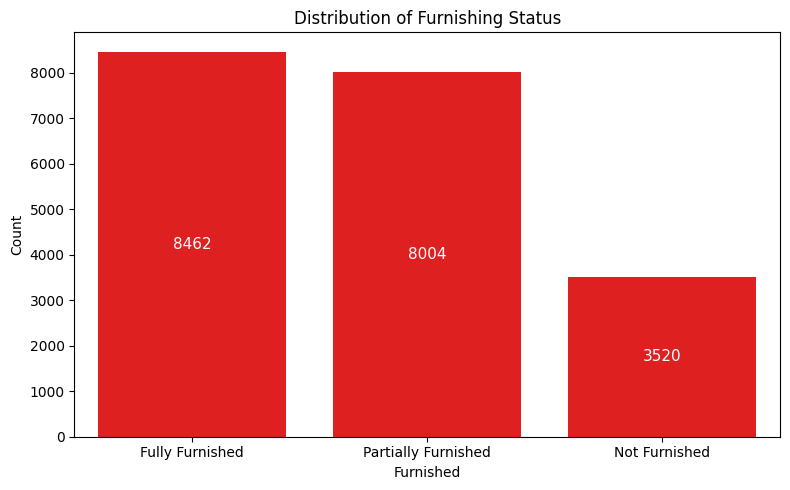

In [242]:
# Bar plot_Distribution of Furnishing Status

plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x='furnished', color='red')

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., count / 2),
                ha='center', va='center', fontsize=11, color='white')

ax.legend_.remove() if ax.legend_ else None

ax.set_title('Distribution of Furnishing Status')
plt.xlabel('Furnished')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


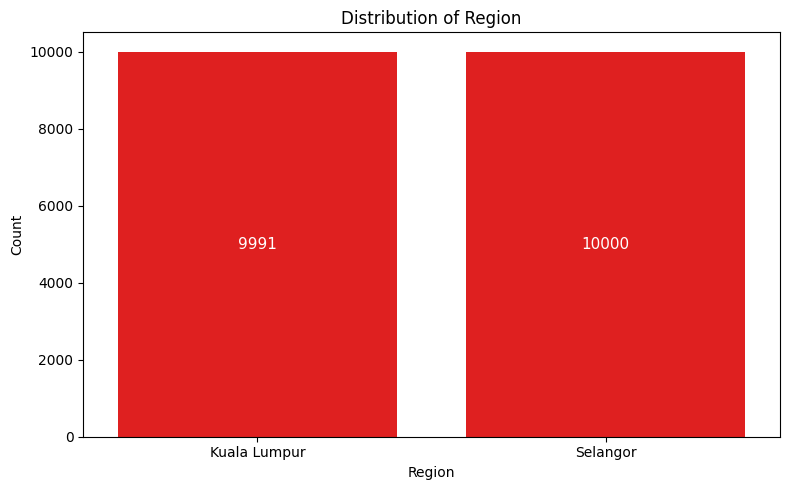

In [243]:
plt.figure(figsize=(8, 5))

ax = sns.countplot(data=df, x='region', color='red')

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}',
                (p.get_x() + p.get_width() / 2., count / 2),
                ha='center', va='center',
                fontsize=11, color='white')

if ax.get_legend() is not None:
    ax.get_legend().remove()

ax.set_title('Distribution of Region')
plt.xlabel('Region')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

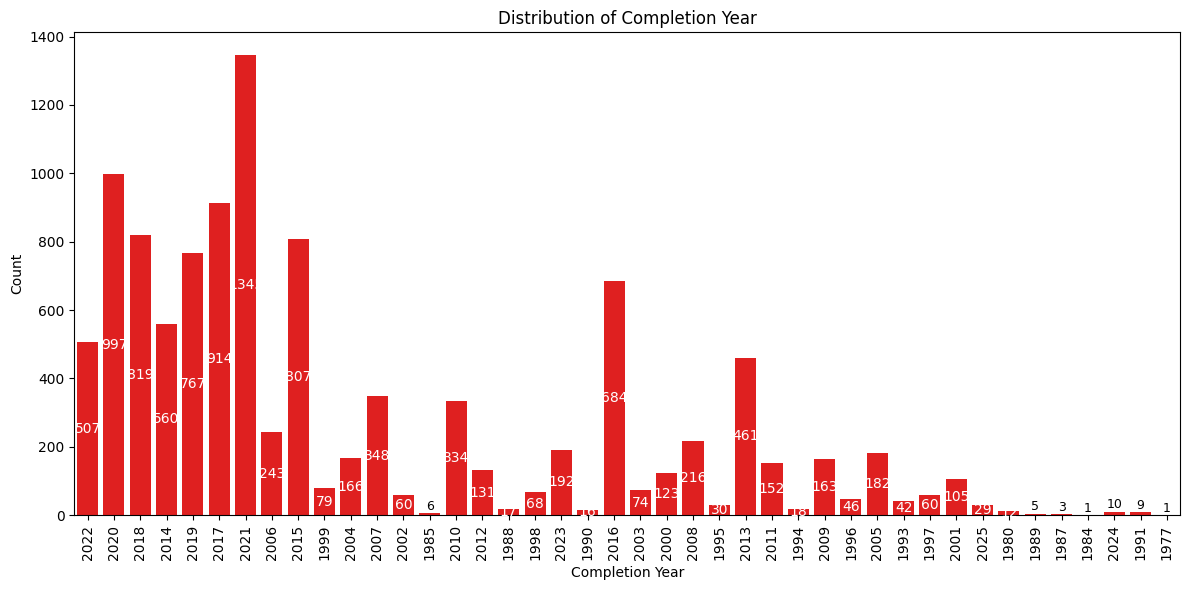

In [244]:
df['completion_year'] = df['completion_year'].dropna().astype(int)

plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_completion, x='completion_year', color='red')

for p in ax.patches:
    count = int(p.get_height())
    if count > 10:
        ax.annotate(f'{count}',
                    (p.get_x() + p.get_width() / 2., count / 2),
                    ha='center', va='center',
                    fontsize=10, color='white')
    else:
        ax.annotate(f'{count}',
                    (p.get_x() + p.get_width() / 2., count + 1),
                    ha='center', va='bottom',
                    fontsize=9, color='black')

if ax.get_legend() is not None:
    ax.get_legend().remove()

ax.set_title('Distribution of Completion Year')
plt.xlabel('Completion Year')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

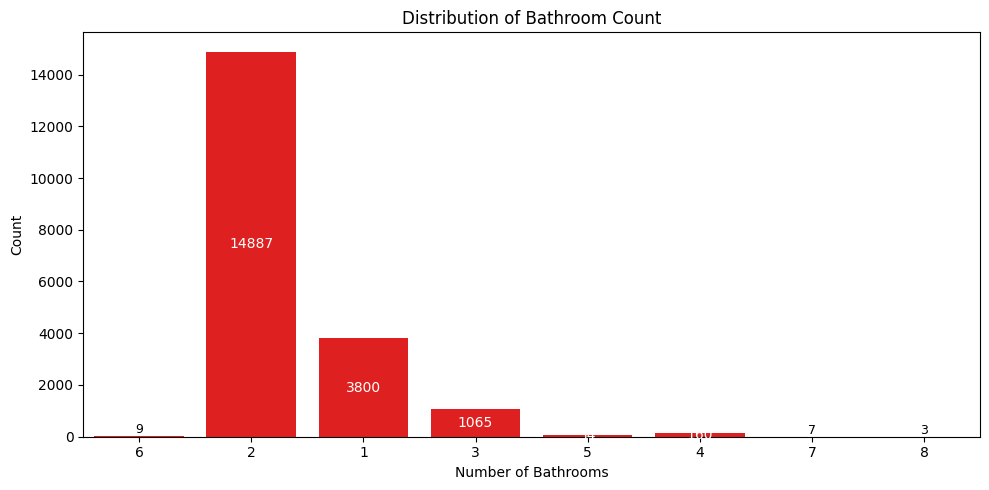

In [245]:
df['bathroom'] = pd.to_numeric(df['bathroom'], errors='coerce')
df_bathroom = df[df['bathroom'].notna()].copy()
df_bathroom['bathroom'] = df_bathroom['bathroom'].astype(int).astype(str)

plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df_bathroom, x='bathroom', color='red')

for p in ax.patches:
    count = int(p.get_height())
    if count > 10:
        ax.annotate(f'{count}',
                    (p.get_x() + p.get_width() / 2., count / 2),
                    ha='center', va='center',
                    fontsize=10, color='white')
    else:
        ax.annotate(f'{count}',
                    (p.get_x() + p.get_width() / 2., count + 1),
                    ha='center', va='bottom',
                    fontsize=9, color='black')

ax.set_title('Distribution of Bathroom Count')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Count')
plt.tight_layout()

if ax.get_legend() is not None:
    ax.get_legend().remove()

plt.show()


*   "Fully Furnished" has the highest count among furnishing statuses, and there are 5 missing values in this column.
*   Kuala Lumpur and Selangor have nearly the same number of rental listings.
*   More rental listings appeared in 2021 than in any other year.
*   Most rental properties have 2 bathrooms, and there are 3 listings with 8 bathrooms.

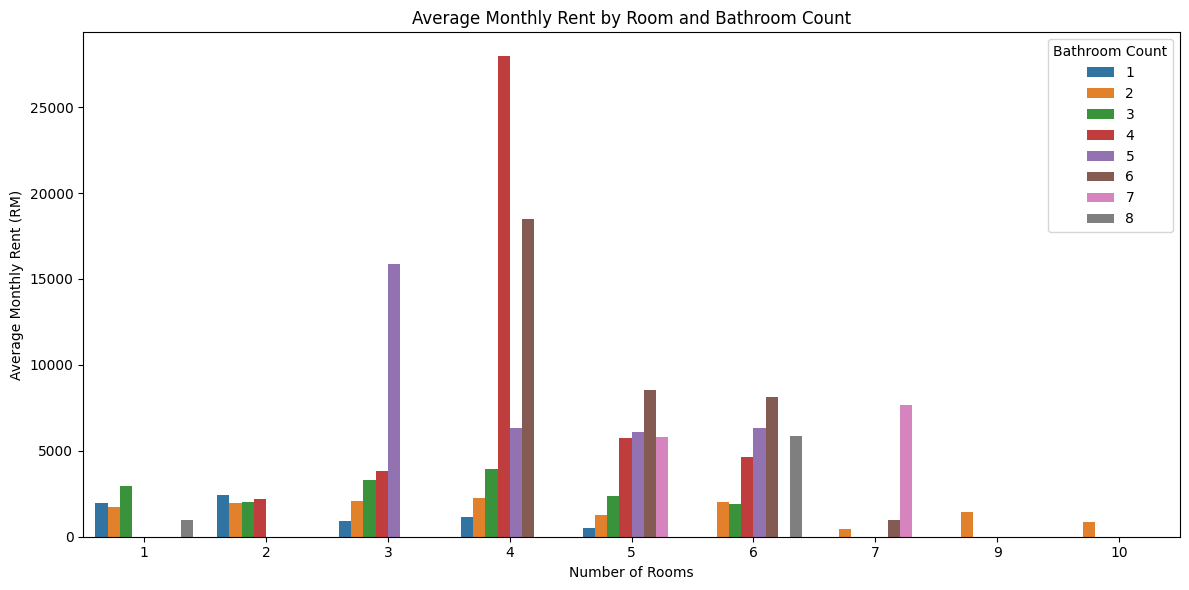

In [246]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_bar = df[['rooms', 'bathroom', 'monthly_rent_rm']].dropna()

df_bar['rooms'] = pd.to_numeric(df_bar['rooms'], errors='coerce')
df_bar['bathroom'] = pd.to_numeric(df_bar['bathroom'], errors='coerce')

df_bar = df_bar.dropna(subset=['rooms', 'bathroom'])

df_bar['rooms'] = df_bar['rooms'].astype(int)
df_bar['bathroom'] = df_bar['bathroom'].astype(int)

room_order = sorted(df_bar['rooms'].unique())
df_bar['rooms'] = pd.Categorical(df_bar['rooms'], categories=room_order, ordered=True)

df_grouped = df_bar.groupby(['rooms', 'bathroom'])['monthly_rent_rm'].mean().reset_index()

df_grouped['bathroom'] = df_grouped['bathroom'].astype(str)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_grouped, x='rooms', y='monthly_rent_rm', hue='bathroom')

ax.set_title('Average Monthly Rent by Room and Bathroom Count')
ax.set_xlabel('Number of Rooms')
ax.set_ylabel('Average Monthly Rent (RM)')
plt.legend(title='Bathroom Count')
plt.tight_layout()
plt.show()

**Based on the chart, houses with 4 rooms and 4–6 bathrooms have the highest average monthly rent, indicating that larger units with more bathrooms tend to command higher rental prices.**

In [248]:
# Parallel Coordinate Plot
# Normalization is performed to improve the visualization of the parallel coordinates plot.


In [249]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

df_encoded = df.copy()

df_encoded['property_type'] = df_encoded['property_type'].astype('category').cat.codes

df_encoded['rooms'] = pd.to_numeric(df_encoded['rooms'].replace({'More than 10': 11}), errors='coerce')
df_encoded['parking'] = pd.to_numeric(df_encoded['parking'], errors='coerce')

df_norm = df_encoded[['property_type', 'rooms', 'parking', 'monthly_rent_rm']].dropna()
df_norm = df_norm[df_norm['monthly_rent_rm'] < 20000]

scaler = MinMaxScaler()
df_norm[['property_type', 'rooms', 'parking']] = scaler.fit_transform(df_norm[['property_type', 'rooms', 'parking']])

fig = go.Figure(data=go.Parcoords(
    line=dict(
        color=df_norm['monthly_rent_rm'],
        colorscale='Turbo',
        showscale=True,
        cmin=df_norm['monthly_rent_rm'].min(),
        cmax=df_norm['monthly_rent_rm'].max(),
        colorbar=dict(title='Monthly Rent (RM)')
    ),
    dimensions=[
        dict(label='Property Type', values=df_norm['property_type']),
        dict(label='Rooms', values=df_norm['rooms']),
        dict(label='Parking', values=df_norm['parking']),
    ]
))

fig.update_layout(title='Parallel Coordinates Plot of Property Features', font=dict(size=14))
fig.show()

The parallel coordinates plot is used to visualize the relationships between normalized variables: `property_type`, `rooms`, and parking, colored by `monthly_rent_rm`. Each line represents one property, connecting values of different features.

From the plot, we can observe that properties with more rooms and more parking tend to have higher rental prices (represented by redder lines), whereas smaller units with fewer rooms and parking are associated with lower rental prices (bluer lines).

However, due to uncleaned data and outliers, the plot may appear cluttered and patterns may be less obvious. Additional cleaning or filtering may help highlight stronger trends.

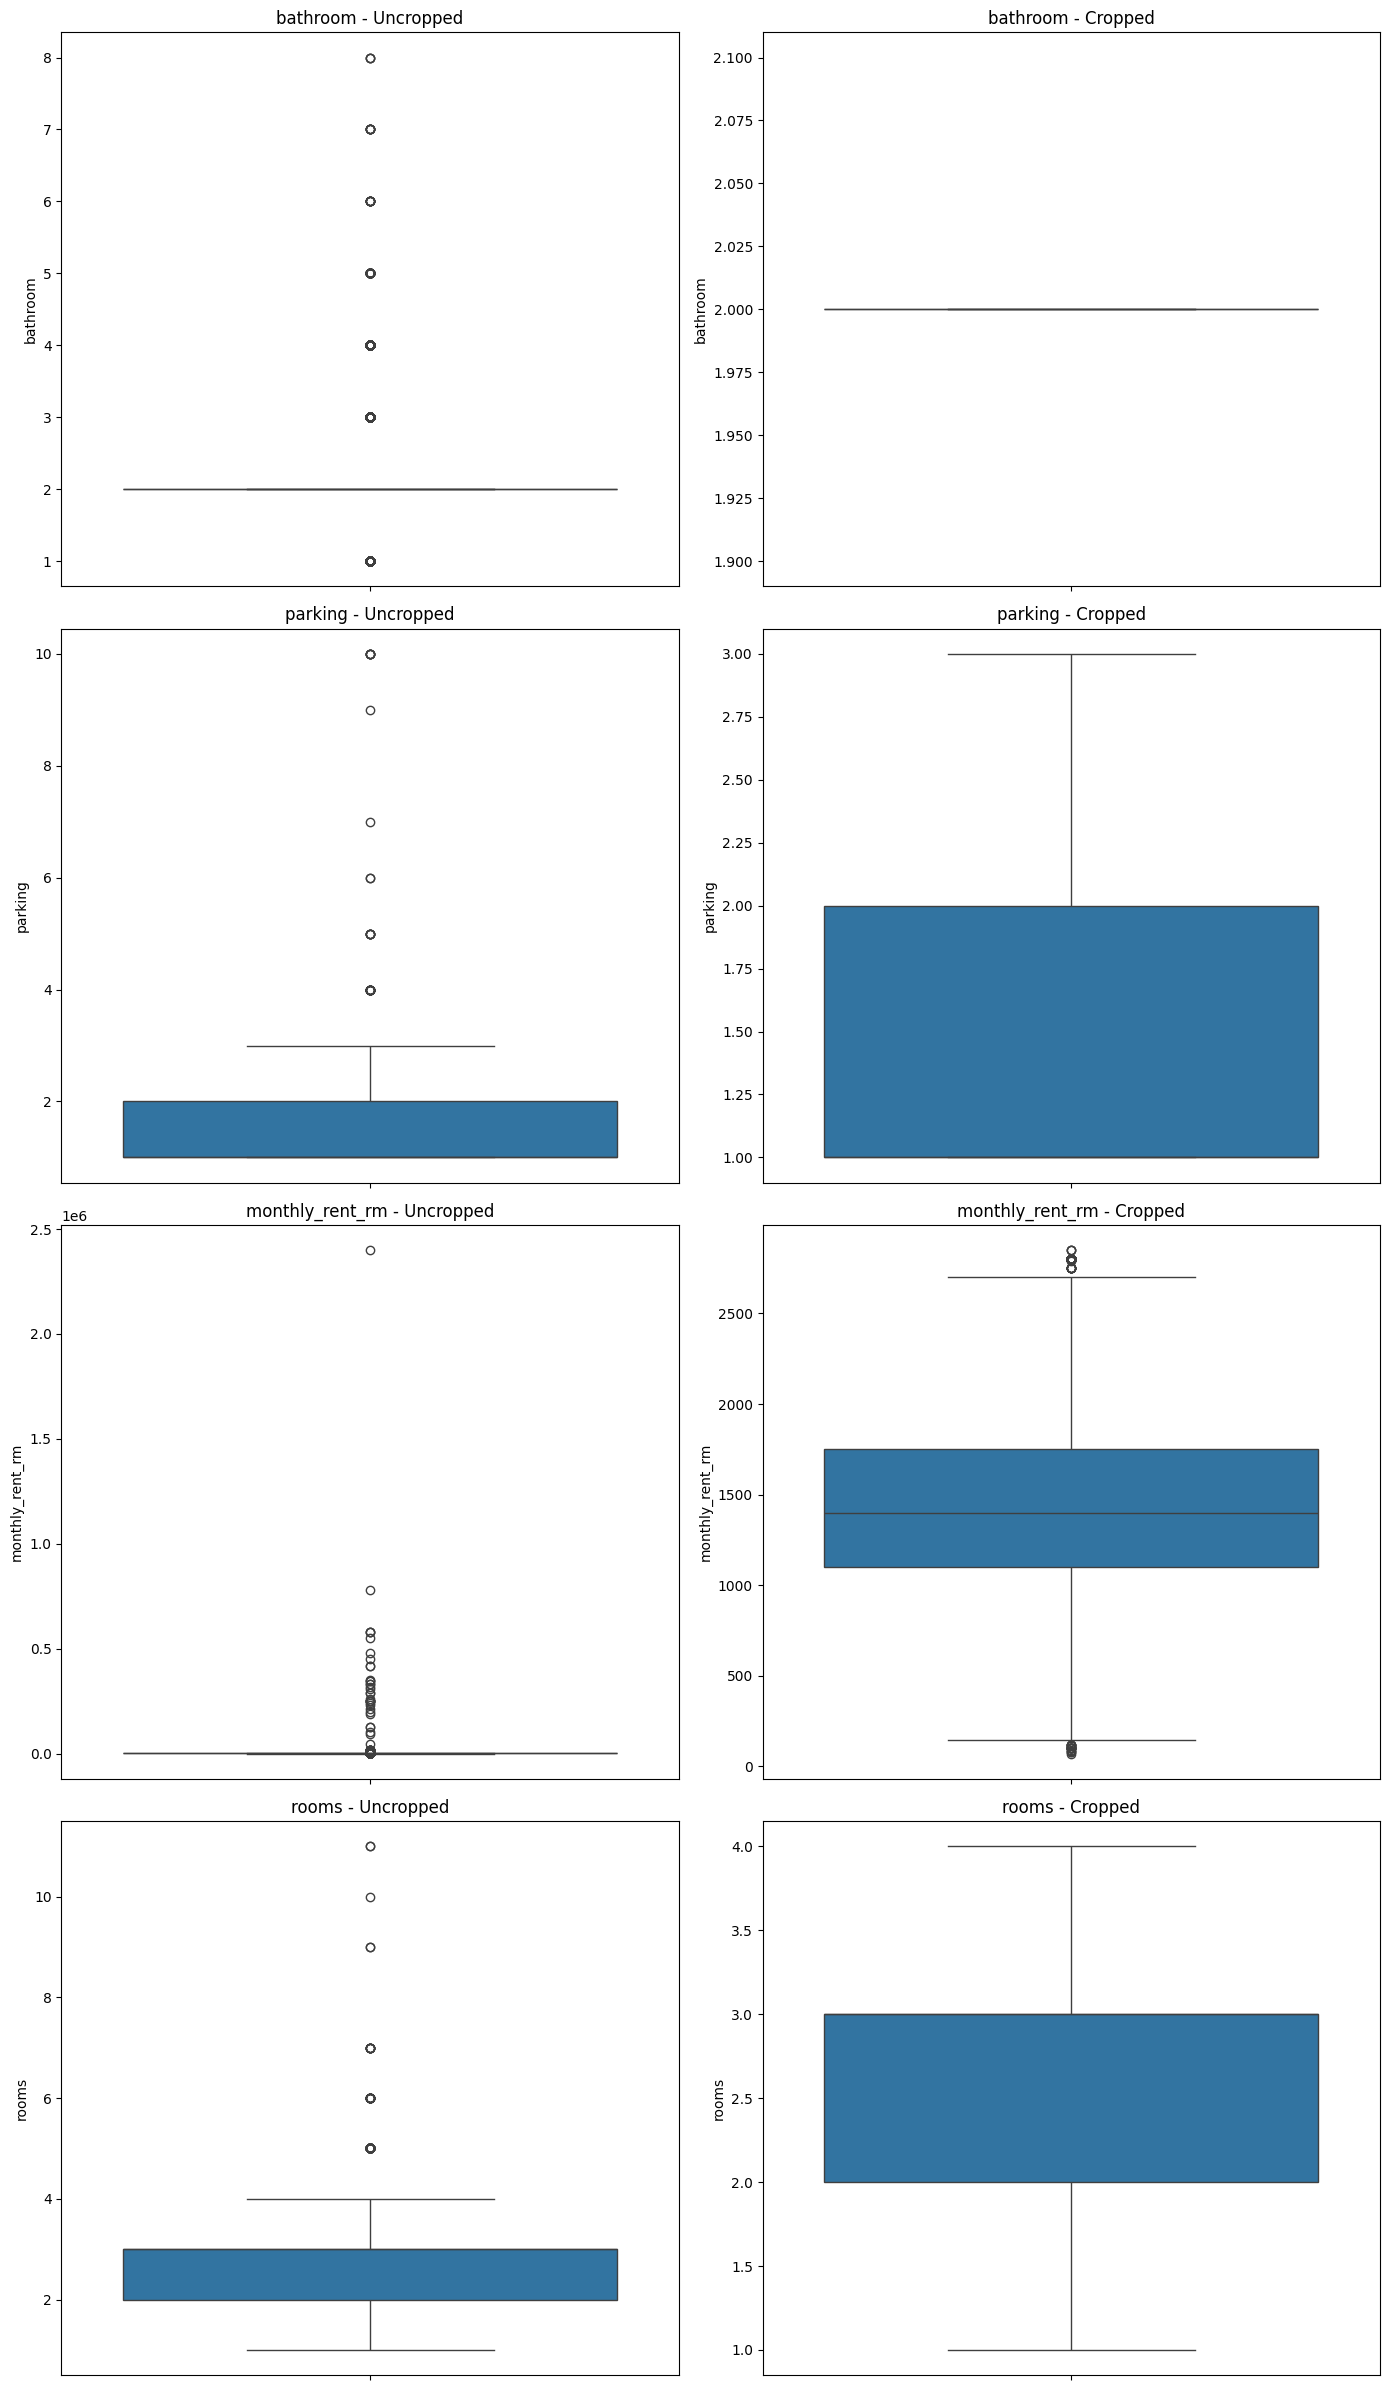

In [250]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


df['rooms'] = pd.to_numeric(df['rooms'].replace({'More than 10': 11}), errors='coerce')
df['parking'] = pd.to_numeric(df['parking'], errors='coerce')
df['bathroom'] = pd.to_numeric(df['bathroom'], errors='coerce')
df['monthly_rent_rm'] = pd.to_numeric(df['monthly_rent_rm'], errors='coerce')

variables = ['bathroom', 'parking', 'monthly_rent_rm', 'rooms']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 24))
axes = axes.flatten()

for i, var in enumerate(variables):
    series = df[var].dropna()

    sns.boxplot(y=series, ax=axes[2*i])
    axes[2*i].set_title(f'{var} - Uncropped')

    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    cropped = series[(series >= lower) & (series <= upper)]

    sns.boxplot(y=cropped, ax=axes[2*i + 1])
    axes[2*i + 1].set_title(f'{var} - Cropped')

plt.tight_layout()
plt.show()

We can observed significant outliers in rooms, parking, and bathrooms.

After applying IQR-based cropping, most distributions appeared more consistent and reliable for downstream modeling.

In [201]:
# Pie Chart for nominal variables

In [251]:
#This is an interactive pie chart. You can click on each color segment to highlight it and view its proportion more clearly.
import plotly.express as px

fig = px.pie(df, names='furnished', title='Distribution of Furnished Status')
fig.show()

In [252]:
#This is an interactive pie chart. You can click on each color segment to highlight it and view its proportion more clearly.

def create_pie_chart_plotly(df, column, title=None):
    fig = px.pie(df, names=column, title=title if title else f'Distribution of {column}')
    fig.show()

create_pie_chart_plotly(df, "property_type", title="Distribution of Property Types")


In [253]:
#This is an interactive pie chart. You can click on each color segment to highlight it and view its proportion more clearly.

def create_pie_chart_plotly(df, column, title=None):
    fig = px.pie(df, names=column, title=title if title else f'Distribution of {column}')
    fig.show()

create_pie_chart_plotly(df, "region", title="Distribution of Region")


I used pie charts to provide an overview of the distribution of nominal variables. As shown, all nominal variables exhibit fairly balanced distributions, except for `property_type`. For `property_type`, more than 95% of the data falls under Apartment, Condominium, and Service Residence."

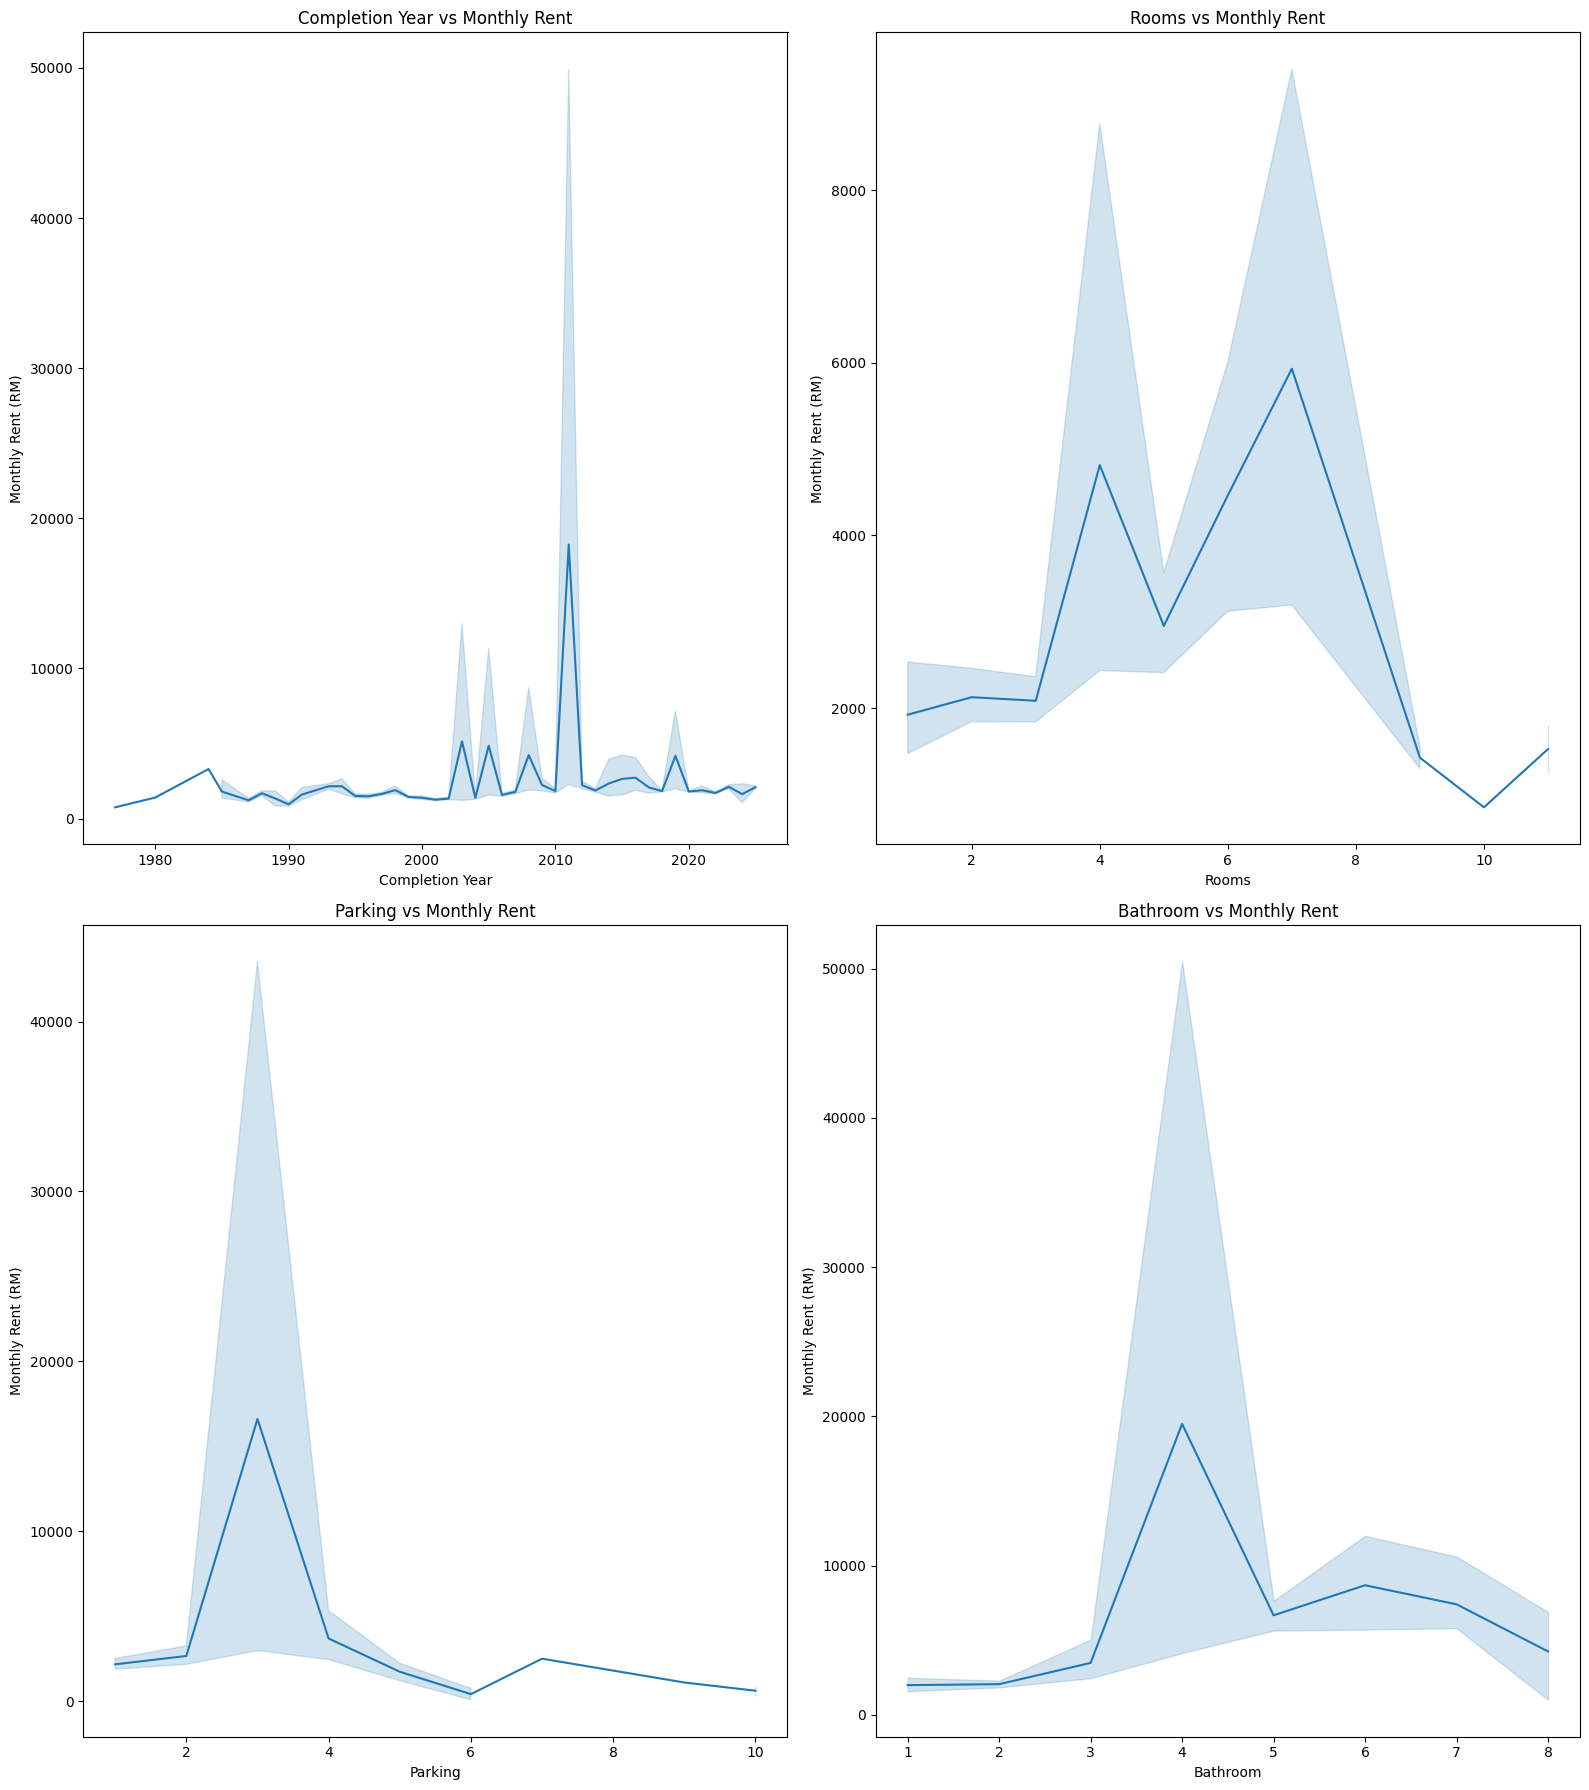

In [254]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


numeric_vars = ['completion_year', 'rooms', 'parking', 'bathroom']
for col in numeric_vars:
    df[col] = pd.to_numeric(df[col], errors='coerce')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 18))
axes = axes.flatten()

titles = [f'{v.replace("_", " ").title()} vs Monthly Rent' for v in numeric_vars]

for i, var in enumerate(numeric_vars):
    temp_df = df[[var, 'monthly_rent_rm']].dropna()
    if not temp_df.empty:
        sns.lineplot(data=temp_df, x=var, y='monthly_rent_rm', ax=axes[i])
        axes[i].set_title(titles[i])
        axes[i].set_xlabel(var.replace('_', ' ').title())
        axes[i].set_ylabel('Monthly Rent (RM)')
    else:
        axes[i].text(0.5, 0.5, f"No valid data for {var}", ha='center')
        axes[i].axis('off')

if len(numeric_vars) < len(axes):
    axes[-1].axis('off')


plt.tight_layout()
plt.show()




#1. Completion Year vs Monthly Rent
Newer properties (post-2000) show more stable rental prices around RM 800, whereas older buildings have more variation and some extremely low rents. This might be due to deterioration or smaller sample size in earlier years.


#2. Rooms vs Monthly Rent
Generally, properties with 1–3 rooms have relatively high average rents. However, rent surprisingly decreases for 4–6 rooms, possibly due to shared housing. A sharp increase at 10 rooms may indicate luxury or commercial properties.

#3. Parking vs Monthly Rent

Units with 1–2 parking spaces have higher and more stable rents. Units with 6 or more parking spaces show wide variability and lower average rent, which could be influenced by outliers or niche property types.

#4. Bathroom vs Monthly Rent

Rent increases with bathroom count up to 2, but adding more bathrooms beyond that does not guarantee higher rent. The rent for units with 4 bathrooms is actually lower, suggesting diminishing returns or data sparsity.


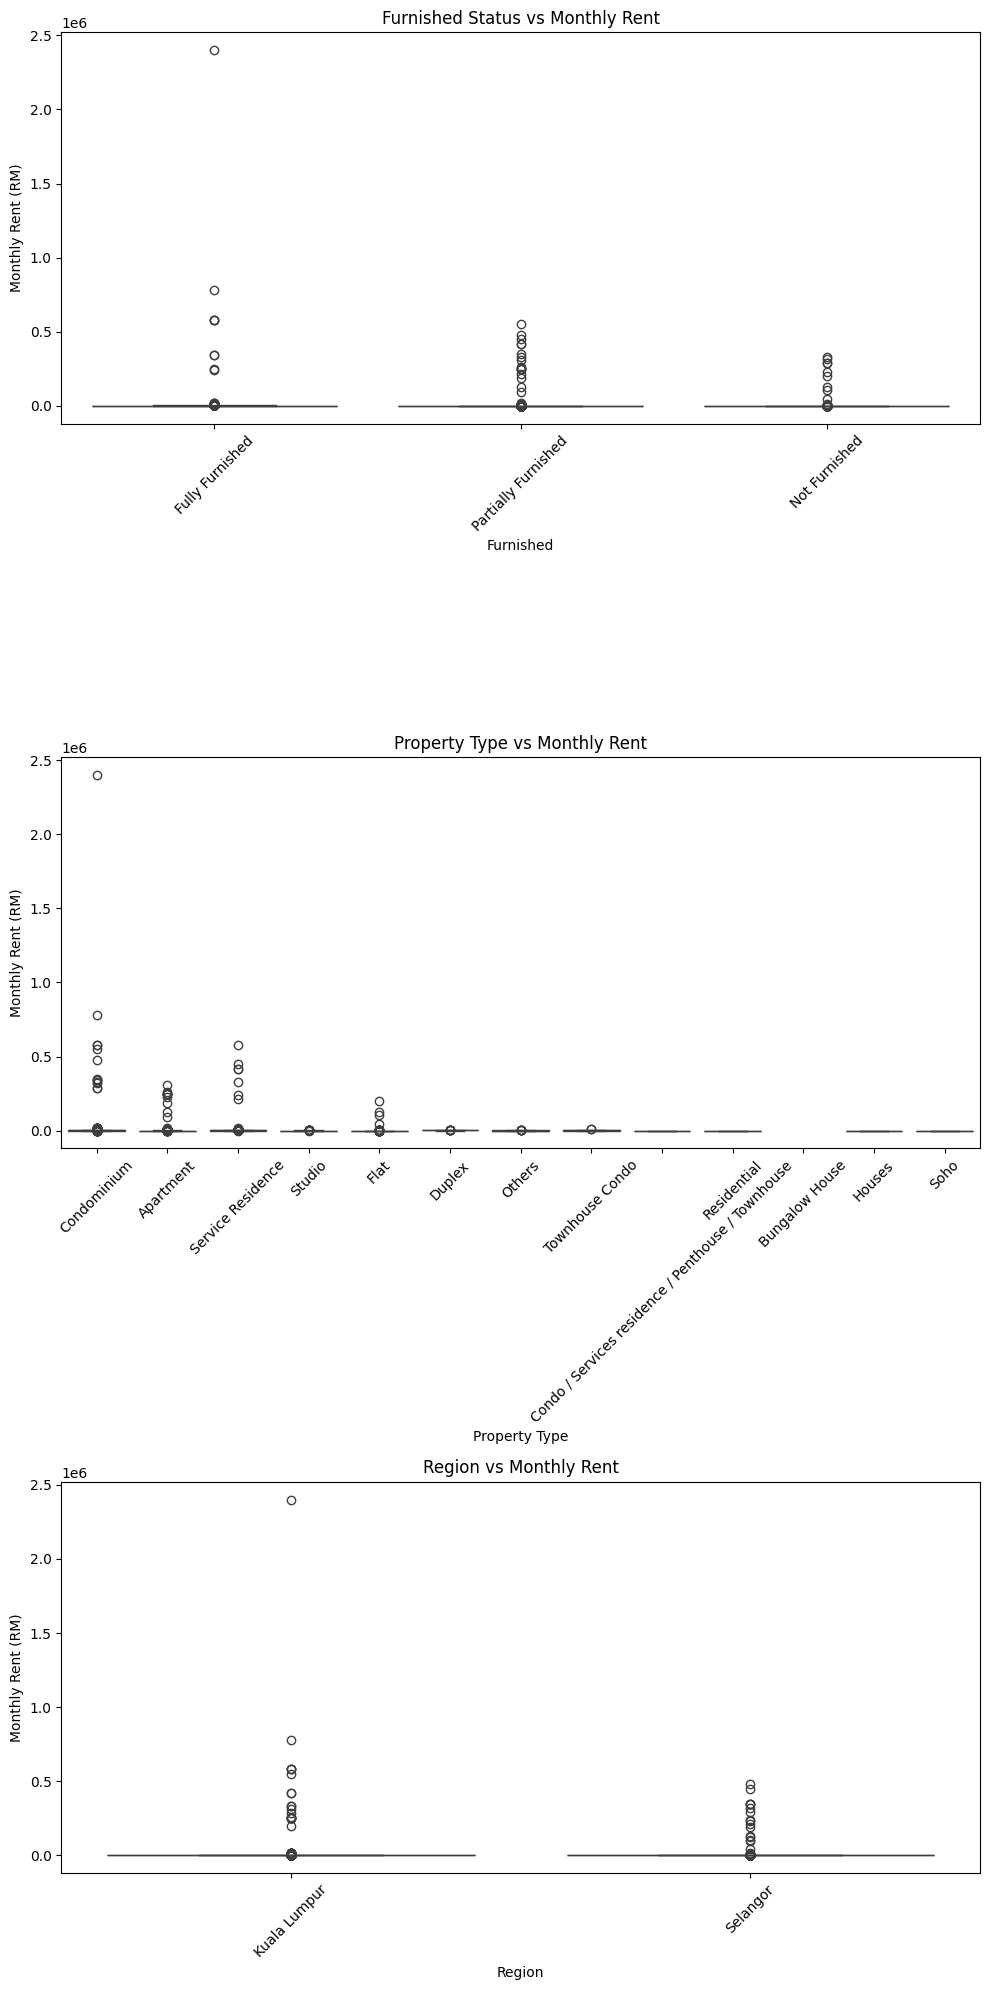

In [255]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
axes = axes.flatten()

cat_vars = ['furnished', 'property_type', 'region']
titles = ['Furnished Status vs Monthly Rent',
          'Property Type vs Monthly Rent',
          'Region vs Monthly Rent']

for i, var in enumerate(cat_vars):
    sns.boxplot(data=df, x=var, y='monthly_rent_rm', ax=axes[i])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel(var.replace('_', ' ').title())
    axes[i].set_ylabel('Monthly Rent (RM)')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# 1. Furnished Status vs Monthly Rent
Fully furnished and partially furnished properties tend to have higher median rental prices compared to non-furnished units. However, all categories show a wide range of rent values with visible outliers, indicating rental price variation within each furnishing group.

#2. Property Type vs Monthly Rent
Apartments, condominiums, and service residences dominate the dataset and show relatively similar rent distributions, though service residences have a slightly higher median. Less common property types such as "Studio," "Flat," and "Duplex" also show consistent distributions. Some rare types (e.g., “Soho,” “Residential”) appear to have either very few listings or inconsistent rent values, resulting in narrow or flat boxplots.

#3. Region vs Monthly Rent
Properties in Kuala Lumpur tend to have slightly higher rent compared to those in Selangor. Both regions exhibit a similar spread in rental prices and contain lower-end outliers. The median rental price is slightly above RM 800 for both regions.



##Data cleaning after visualization

In [256]:
df.head()

,completion_year,monthly_rent_rm,property_type,rooms,parking,bathroom,size_sqft,furnished,region,location_cleaned,location_encoded,nearby_ktm_lrt,fac_count,add_fac_count
0,2022.0,4200.0,Condominium,5.0,2.0,6.0,1842,Fully Furnished,Kuala Lumpur,Kuala Lumpur,1,False,10.0,3.0
1,NaN,2300.0,Condominium,3.0,1.0,2.0,1170,Partially Furnished,Kuala Lumpur,Kuala Lumpur,1,True,9.0,3.0
2,NaN,1000.0,Apartment,3.0,NaN,2.0,650,Fully Furnished,Kuala Lumpur,Kuala Lumpur,1,False,4.0,NaN
3,2020.0,1700.0,Apartment,2.0,1.0,2.0,743,Partially Furnished,Kuala Lumpur,Kuala Lumpur,1,True,8.0,3.0
4,NaN,1299.0,Service Residence,1.0,1.0,1.0,494,Not Furnished,Kuala Lumpur,Kuala Lumpur,1,False,11.0,1.0


In [257]:
# Noise/outliers processing
# After visualizing the data, I filtered the most appropriate ranges for the numeric variables to remove outliers and ensure data quality.
# Regarding property_type, I found that approximately 95% of the listings fall into three categories: “Apartment,” “Condominium,” and “Service Residence.”
# Therefore, I retained only these types for further analysis.

df1 = df.copy()

df1 = df1[(df1['monthly_rent_rm'] > 400) & (df1['monthly_rent_rm'] < 3500)]
df1 = df1[(df1['size_sqft'] > 100) & (df1['size_sqft'] < 2000)]
df1 = df1[(df1['rooms'] > 0) & (df1['rooms'] < 4)]
df1 = df1[(df1['parking'] > 0) & (df1['parking'] < 4)]
df1 = df1[(df1['bathroom'] > 0) & (df1['bathroom'] < 4)]

df1 = df1[df1['property_type'].isin(["Apartment", "Condominium", "Service Residence"])]


In [258]:
# converts the furnished column from text categories (e.g., "Fully Furnished") into numeric values.

furnish_map = {"Not Furnished": 1, "Partially Furnished": 2, "Fully Furnished": 3}
df1["furnished"] = df1["furnished"].map(furnish_map).round()

# encodes the region column into numeric form: “Kuala Lumpur” → 1，“Selangor” → 2
region_map = {"Kuala Lumpur": 1, "Selangor": 2}
df1["region"] = df1["region"].map(region_map).round()

# converts the nearby_ktm_lrt column from boolean values into numeric: True (property is near KTM/LRT) → 1，False (not near KTM/LRT) → 2
ktm_map = {True: 1, False: 2}
df1["nearby_ktm_lrt"] = df1["nearby_ktm_lrt"].map(ktm_map).round()

#This step transforms the property_type column into numeric labels for modeling: “Condominium” → 1，“Apartment” → 2，“Service Residence” → 3
property_map = {"Condominium": 1, "Apartment": 2, "Service Residence": 3}
df1["property_type"] = df1["property_type"].map(property_map).round()

In [259]:
# count unique value for categorical data
is_categorical = df1.select_dtypes(include=['object'])

print("The number of unique values for categorical data:")
for col in is_categorical.columns:
    unique_count = df1[col].nunique()
    print(f"{col}: {unique_count} unique values")


The number of unique values for categorical data:
location_cleaned: 2 unique values


In [260]:
location_map = {"Kuala Lumpur": 1, "Selangor": 2}
df1["location_cleaned"] = df1["location_cleaned"].map(location_map)

In [261]:
# count again unique value for categorical data
is_categorical = df1.select_dtypes(include=['object'])

print("The number of unique values for categorical data:")
for col in is_categorical.columns:
    unique_count = df1[col].nunique()
    print(f"{col}: {unique_count} unique values")


The number of unique values for categorical data:


In [262]:
print(df1.shape)
print(df1.head())


(12308, 14)
   completion_year  monthly_rent_rm  property_type  rooms  parking  bathroom  \
1              NaN           2300.0              1    3.0      1.0       2.0   
3           2020.0           1700.0              2    2.0      1.0       2.0   
4              NaN           1299.0              3    1.0      1.0       1.0   
5              NaN           1500.0              2    3.0      1.0       2.0   
6              NaN           2900.0              3    3.0      2.0       2.0   

   size_sqft  furnished  region  location_cleaned  location_encoded  \
1       1170          2       1                 1                 1   
3        743          2       1                 1                 1   
4        494          1       1                 1                 1   
5        884          2       1                 1                 1   
6        982          3       1                 1                 1   

   nearby_ktm_lrt  fac_count  add_fac_count  
1               1        9.0      

In [263]:
# found missing values only in numerical columns, not in categorical ones like location.
# To impute the missing values, I used the mode (most frequent value) rather than the mean, since variables like parking require integer values.

from sklearn.impute import SimpleImputer
import pandas as pd

num_cols = df1.select_dtypes(include=['float64', 'int64']).columns
X_num = df1[num_cols]

imputer = SimpleImputer(strategy='most_frequent')
X_num_imputed = pd.DataFrame(imputer.fit_transform(X_num), columns=num_cols)

print(X_num_imputed.isna().sum())


completion_year     0
monthly_rent_rm     0
property_type       0
rooms               0
parking             0
bathroom            0
size_sqft           0
furnished           0
region              0
location_cleaned    0
location_encoded    0
nearby_ktm_lrt      0
fac_count           0
add_fac_count       0
dtype: int64


## Split the dataset: 70:15:15

In [270]:
# Be
fore building the regression models, I set monthly_rent_rm as the target variable (y) and the remaining features as predictors (X).
# Then, I split the dataset into training, validation, and testing sets: 70:15:15
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X1 = df1.drop(columns=['monthly_rent_rm'])
y1 = df1['monthly_rent_rm']

scaler = StandardScaler()
X_clean1 = scaler.fit_transform(X1)

X_temp, X_test_val, y_temp, y_test_val = train_test_split(X_clean1, y1, test_size=0.30, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=123)

print("Train set:", X_temp.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)


Train set: (8615, 13)
Validation set: (1846, 13)
Test set: (1847, 13)


##Train linear regression model

In [278]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import time

X_temp_df = pd.DataFrame(X_temp)
y_temp_series = pd.Series(y_temp).reset_index(drop=True)
train_df = pd.concat([X_temp_df, y_temp_series.rename("monthly_rent_rm")], axis=1)
train_df_clean = train_df.dropna()

X_temp_clean = train_df_clean.drop(columns=["monthly_rent_rm"]).values
y_temp_clean = train_df_clean["monthly_rent_rm"].values

start_time = time.time()
model_lr = LinearRegression()
model_lr.fit(X_temp_clean, y_temp_clean)
end_time = time.time()
print("Training time: {:.2f} seconds".format(end_time - start_time))

y_pred_train = model_lr.predict(X_temp_clean)
mse = mean_squared_error(y_temp_clean, y_pred_train)
mae = mean_absolute_error(y_temp_clean, y_pred_train)
r2 = r2_score(y_temp_clean, y_pred_train)

print("===== Train Performance =====")
print(f"Train MSE: {mse:.2f}")
print(f"Train MAE: {mae:.2f}")
print(f"Train R²: {r2:.2f}")

Training time: 0.07 seconds
===== Train Performance =====
Train MSE: 146830.82
Train MAE: 287.13
Train R²: 0.47


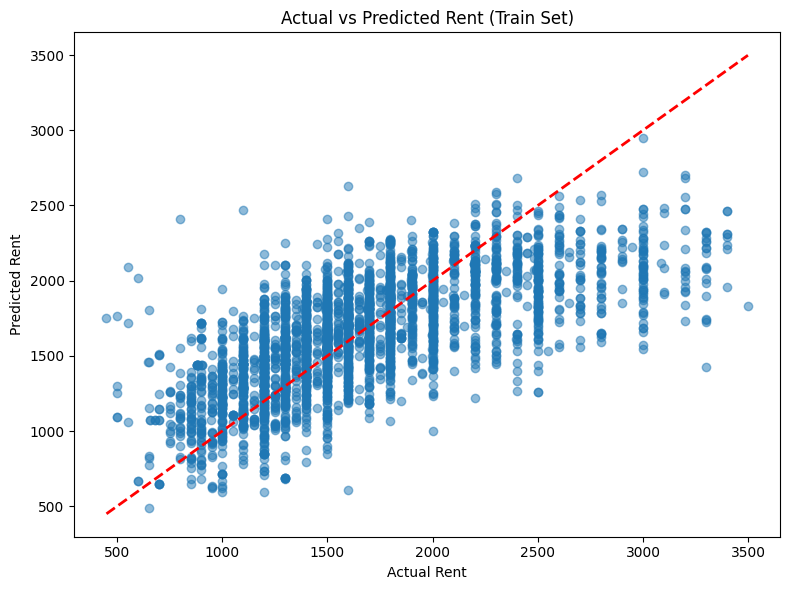

In [279]:
# Actual vs Predicted Rent (Train set) plot
plt.figure(figsize=(8, 6))
plt.scatter(y_temp_clean, y_pred_train, alpha=0.5)
plt.plot([min(y_temp_clean), max(y_temp_clean)], [min(y_temp_clean), max(y_temp_clean)],
         color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.title('Actual vs Predicted Rent (Train Set)')
plt.tight_layout()
plt.show()

In [282]:
# Test Set Evaluation
X_test_df = pd.DataFrame(X_test)
y_test_series = pd.Series(y_test).reset_index(drop=True)
test_df = pd.concat([X_test_df, y_test_series.rename("monthly_rent_rm")], axis=1)
test_df_clean = test_df.dropna()

X_test_clean = test_df_clean.drop(columns=["monthly_rent_rm"]).values
y_test_clean = test_df_clean["monthly_rent_rm"].values

y_pred_test = model_lr.predict(X_test_clean)

mse_test = mean_squared_error(y_test_clean, y_pred_test)
mae_test = mean_absolute_error(y_test_clean, y_pred_test)
r2_test = r2_score(y_test_clean, y_pred_test)

print("\n===== Test Set Performance =====")
print(f"Test MSE: {mse_test:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Test R²: {r2_test:.2f}")


===== Test Set Performance =====
Test MSE: 138270.30
Test MAE: 282.56
Test R²: 0.47


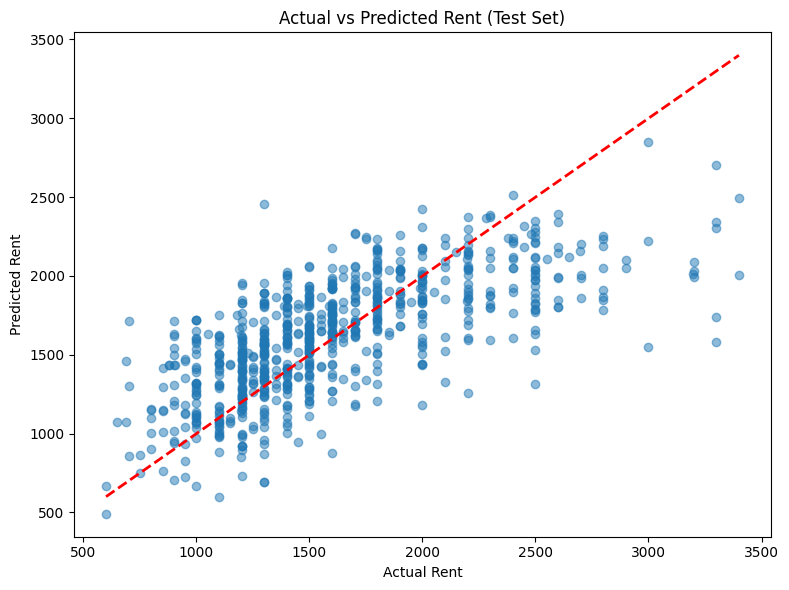

In [283]:
# Actual vs Predicted Rent (Test set) plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_clean, y_pred_test, alpha=0.5)
plt.plot([min(y_test_clean), max(y_test_clean)],
         [min(y_test_clean), max(y_test_clean)],
         color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.title('Actual vs Predicted Rent (Test Set)')
plt.tight_layout()
plt.show()

In [280]:
#Valid Set
X_val_df = pd.DataFrame(X_val)
y_val_series = pd.Series(y_val).reset_index(drop=True)
val_df = pd.concat([X_val_df, y_val_series.rename("monthly_rent_rm")], axis=1)
val_df_clean = val_df.dropna()

X_val_clean = val_df_clean.drop(columns=["monthly_rent_rm"]).values
y_val_clean = val_df_clean["monthly_rent_rm"].values

y_pred_val = model_lr.predict(X_val_clean)
mse_val = mean_squared_error(y_val_clean, y_pred_val)
mae_val = mean_absolute_error(y_val_clean, y_pred_val)
r2_val = r2_score(y_val_clean, y_pred_val)

print("===== Validation Performance =====")
print(f"Validation MSE: {mse_val:.2f}")
print(f"Validation MAE: {mae_val:.2f}")
print(f"Validation R²: {r2_val:.2f}")

===== Validation Performance =====
Validation MSE: 148084.08
Validation MAE: 295.19
Validation R²: 0.45


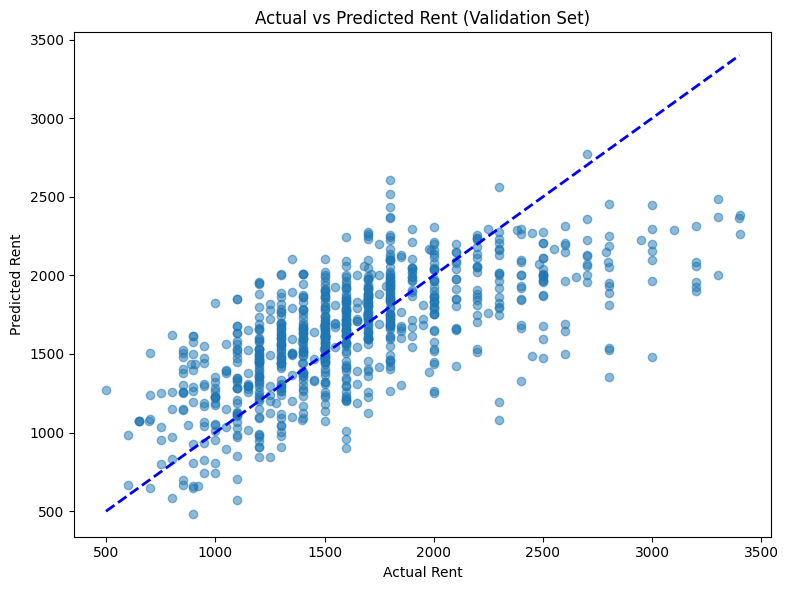

In [281]:
# Actual vs Predicted Rent (Valid set) plot
plt.figure(figsize=(8, 6))
plt.scatter(y_val_clean, y_pred_val, alpha=0.5)
plt.plot([min(y_val_clean), max(y_val_clean)], [min(y_val_clean), max(y_val_clean)],
         color='blue', linestyle='--', linewidth=2)
plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.title('Actual vs Predicted Rent (Validation Set)')
plt.tight_layout()
plt.show()
